In [1]:
!pip install kagglehub polars nbdev

In [2]:
from google.colab import files
files.upload()  # This will prompt you to upload the file.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
import kagglehub
import polars as pl

# Download the competition dataset
train_path = kagglehub.competition_download('drawing-with-llms', 'train.csv')

# Load the dataset into a Polars DataFrame
train = pl.read_csv(train_path)

# Display the first few rows
print(train.head())

shape: (5, 2)
┌────────┬─────────────────────────────────┐
│ id     ┆ description                     │
│ ---    ┆ ---                             │
│ str    ┆ str                             │
╞════════╪═════════════════════════════════╡
│ 04c411 ┆ a starlit night over snow-cove… │
│ 215136 ┆ black and white checkered pant… │
│ 3e2bc6 ┆ crimson rectangles forming a c… │
│ 61d7a8 ┆ burgundy corduroy pants with p… │
│ 6f2ca7 ┆ orange corduroy overalls        │
└────────┴─────────────────────────────────┘


In [4]:
import kagglehub
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import numpy as np
from wordcloud import WordCloud
import os
from IPython.display import display

# Download the competition dataset
train_path = kagglehub.competition_download('drawing-with-llms', 'train.csv')

# Load the dataset into a Polars DataFrame
train = pl.read_csv(train_path)

# Print basic information
print(f"Dataset shape: {train.shape}")
print("\nColumn names:")
print(train.columns)
print("\nSample of the first 5 entries:")
display(train.head(5))

# Analyze text description lengths
# Use Polars syntax instead of pandas
desc_lengths = train.select(pl.col("description").map_elements(len).alias("length"))["length"]
avg_length = desc_lengths.mean()
max_length = desc_lengths.max()
min_length = desc_lengths.min()

print(f"\nDescription Statistics:")
print(f"Average length: {avg_length:.2f} characters")
print(f"Maximum length: {max_length} characters")
print(f"Minimum length: {min_length} characters")



Dataset shape: (15, 2)

Column names:
['id', 'description']

Sample of the first 5 entries:


id,description
str,str
"""04c411""","""a starlit night over snow-cove…"
"""215136""","""black and white checkered pant…"
"""3e2bc6""","""crimson rectangles forming a c…"
"""61d7a8""","""burgundy corduroy pants with p…"
"""6f2ca7""","""orange corduroy overalls"""



Description Statistics:
Average length: 37.33 characters
Maximum length: 61 characters
Minimum length: 13 characters


<ipython-input-4-d92e5208da76>:27: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  desc_lengths = train.select(pl.col("description").map_elements(len).alias("length"))["length"]


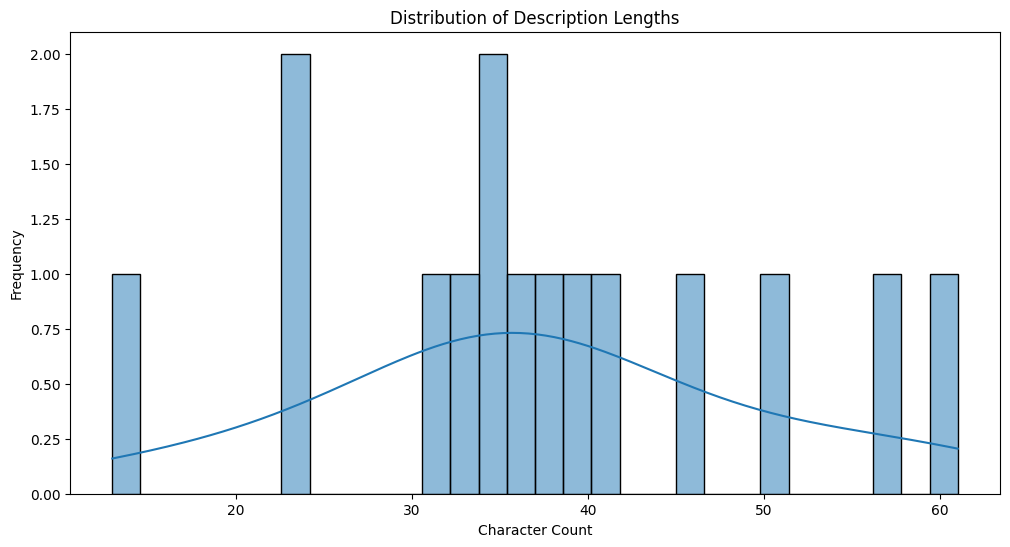

In [5]:
# Convert to Python list for plotting
desc_lengths_list = desc_lengths.to_list()

# Plot description length distribution
plt.figure(figsize=(12, 6))
sns.histplot(desc_lengths_list, bins=30, kde=True)
plt.title("Distribution of Description Lengths")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.show()



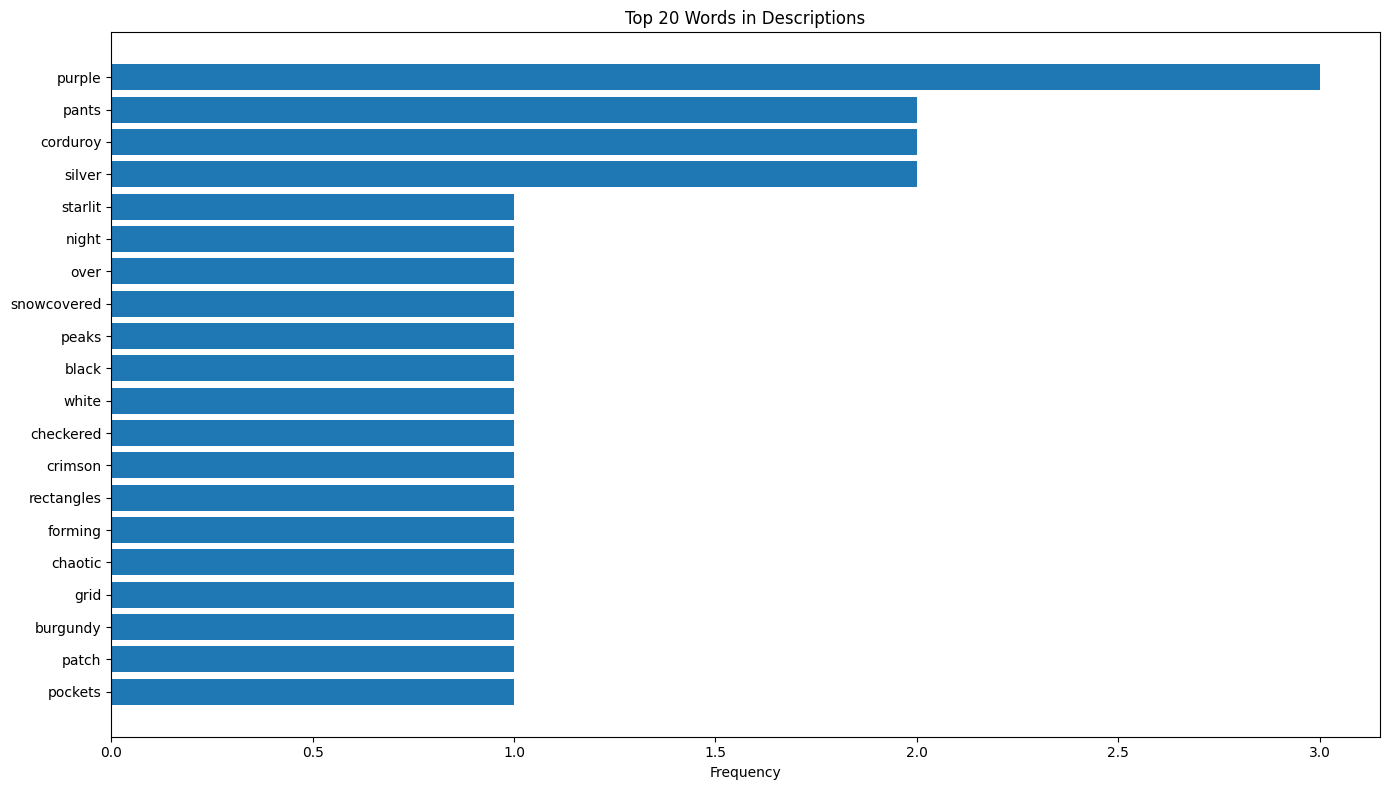

In [6]:
# Analyze common words in descriptions
def extract_keywords(text):
    # Convert to lowercase and remove punctuation
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Split into words
    words = text.split()
    # Remove common stop words
    stop_words = {'a', 'an', 'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'with', 'of', 'by'}
    return [word for word in words if word not in stop_words]

# Extract all words from descriptions
all_words = []
for desc in train["description"].to_list():
    all_words.extend(extract_keywords(desc))

# Count word frequencies
word_counts = Counter(all_words)
top_words = word_counts.most_common(20)

# Plot top words
plt.figure(figsize=(14, 8))
labels, values = zip(*top_words)
plt.barh(range(len(labels)), values, tick_label=labels)
plt.gca().invert_yaxis()  # Invert to show most common at top
plt.title("Top 20 Words in Descriptions")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()



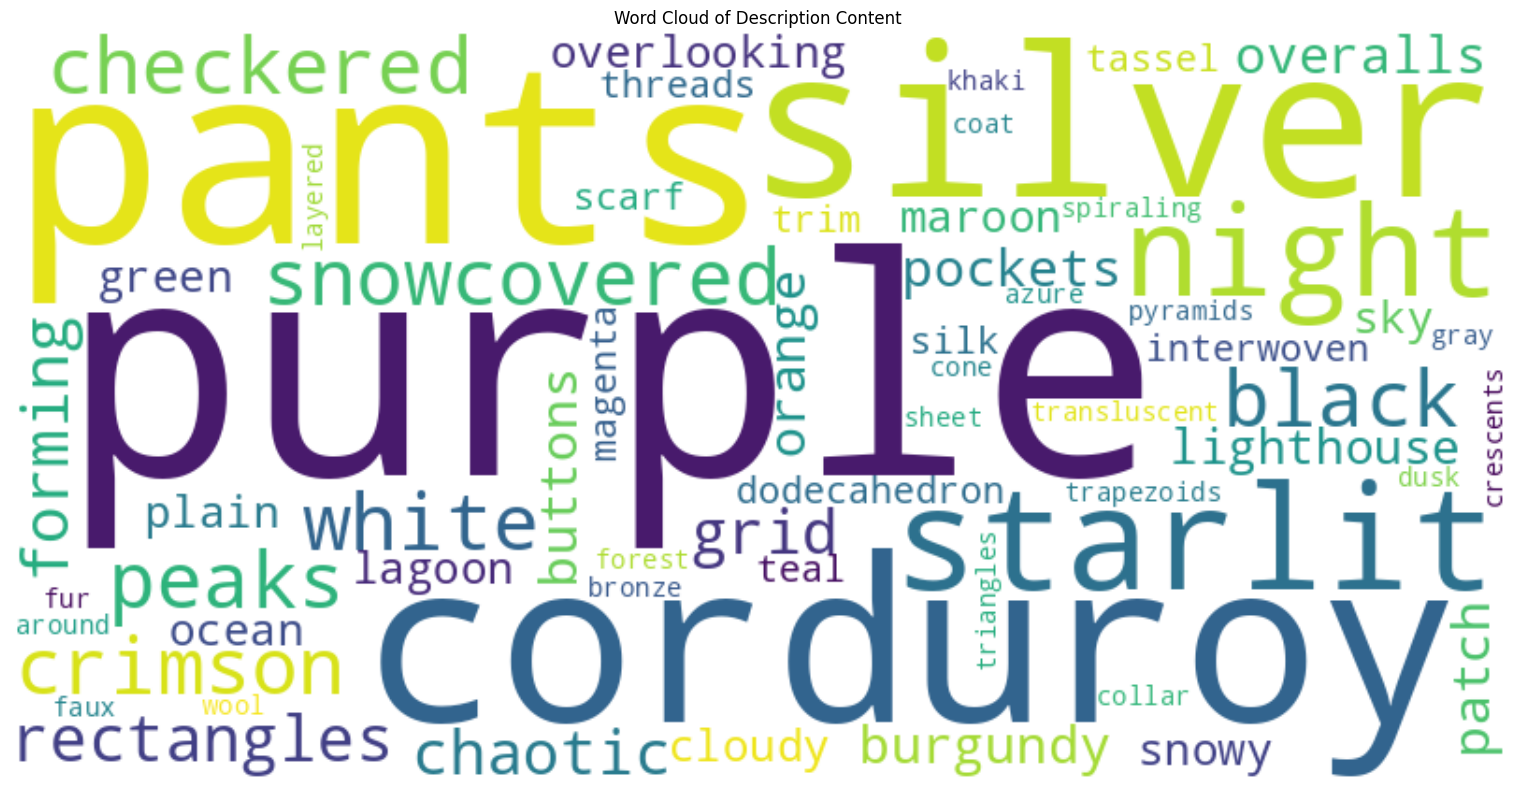

In [7]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',
                     max_words=200, contour_width=3, contour_color='steelblue')
wordcloud.generate(' '.join(all_words))

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Description Content")
plt.tight_layout()
plt.show()


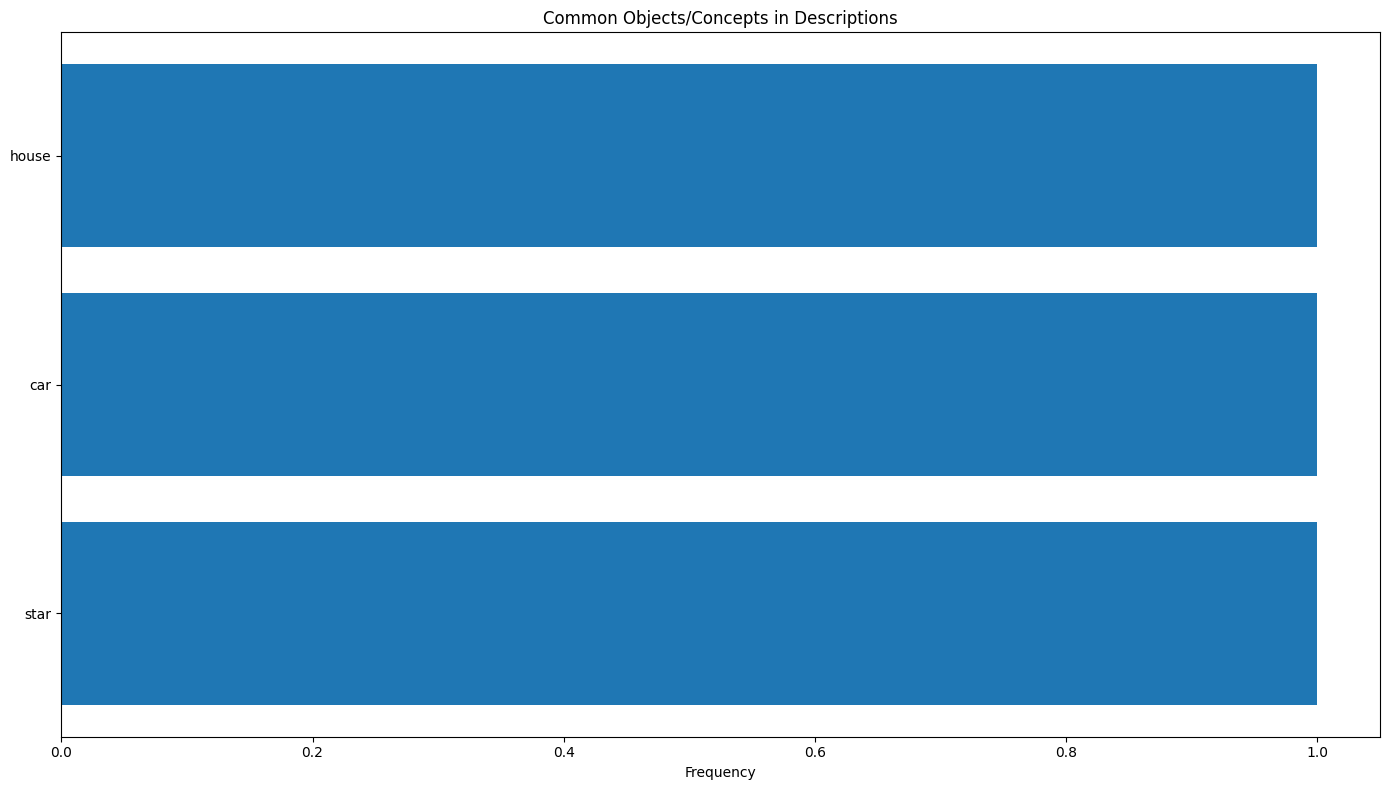

In [8]:

# Analyze potential categories or themes
# Look for common patterns or entities in descriptions
common_objects = ['person', 'animal', 'tree', 'house', 'car', 'bird', 'flower',
                 'mountain', 'water', 'sun', 'moon', 'star', 'building', 'landscape']

object_counts = {obj: 0 for obj in common_objects}
for desc in train["description"].to_list():
    desc_lower = desc.lower()
    for obj in common_objects:
        if obj in desc_lower:
            object_counts[obj] += 1

# Filter to objects that appear at least once
object_counts = {k: v for k, v in object_counts.items() if v > 0}
sorted_objects = sorted(object_counts.items(), key=lambda x: x[1], reverse=True)

if sorted_objects:
    plt.figure(figsize=(14, 8))
    labels, values = zip(*sorted_objects)
    plt.barh(range(len(labels)), values, tick_label=labels)
    plt.gca().invert_yaxis()
    plt.title("Common Objects/Concepts in Descriptions")
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()



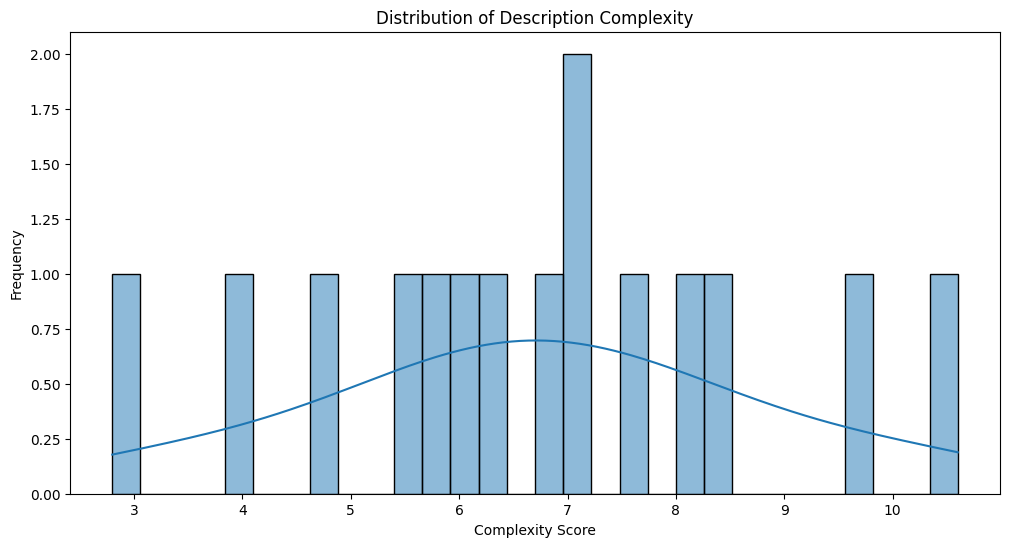

In [9]:
# Check for description complexity
complexity_scores = []
for desc in train["description"].to_list():
    # A simple complexity score based on description length,
    # number of commas (indicating more complex statements),
    # and unique words
    words = desc.lower().split()
    unique_words = len(set(words))
    commas = desc.count(',')
    complexity = (len(desc) * 0.1) + (unique_words * 0.5) + (commas * 2)
    complexity_scores.append(complexity)

plt.figure(figsize=(12, 6))
sns.histplot(complexity_scores, bins=30, kde=True)
plt.title("Distribution of Description Complexity")
plt.xlabel("Complexity Score")
plt.ylabel("Frequency")
plt.show()



In [12]:
!pip install -q cairosvg


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.8 MB/s eta 0:00:00


In [13]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import re
from typing import Dict, Any, List, Optional, Tuple
import random

class Model:
    def __init__(self):
        # Load your LLM model
        self.tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b")
        self.model = AutoModelForCausalLM.from_pretrained(
            "google/gemma-2-9b",
            torch_dtype=torch.bfloat16,
            device_map="auto"
        )

        # Prepare generation prompt
        self.prompt_template = """
        Create an SVG illustration of {description}.

        The SVG should:
        - Be simple and clear
        - Use only basic shapes (circle, rect, path, line, polygon, polyline, ellipse, text)
        - Include the required xmlns="http://www.w3.org/2000/svg" attribute
        - Not include any external images, CSS, or scripts
        - Be less than 10,000 bytes in size

        Return only valid SVG code:
        """

        # Load templates for common objects
        self.templates = self._load_templates()

        # Color palette
        self.colors = {
            "red": "#e74c3c",
            "blue": "#3498db",
            "green": "#2ecc71",
            "yellow": "#f1c40f",
            "orange": "#e67e22",
            "purple": "#9b59b6",
            "gray": "#95a5a6",
            "black": "#2c3e50",
            "white": "#ecf0f1",
            "brown": "#d35400"
        }

    def predict(self, prompt: str) -> str:
        """Generate an SVG based on the given text description."""
        try:
            # Parse the prompt to see if we should use templates
            if self._is_simple_scene(prompt):
                svg_code = self._generate_with_templates(prompt)
            else:
                # Generate SVG using the LLM
                svg_code = self._generate_with_llm(prompt)

            # Basic fixes
            if "xmlns" not in svg_code:
                svg_code = svg_code.replace('<svg', '<svg xmlns="http://www.w3.org/2000/svg"')

            return svg_code

        except Exception as e:
            # Fallback for any errors
            return self._generate_fallback_svg(prompt, str(e))

    def _is_simple_scene(self, prompt: str) -> bool:
        """Check if the prompt describes a simple scene we can handle with templates"""
        simple_objects = ["circle", "square", "rectangle", "triangle", "star",
                         "person", "tree", "house", "sun", "moon", "cloud",
                         "flower", "animal", "car", "heart"]

        # If prompt contains any of these objects, check if it's a simple description
        return any(obj in prompt.lower() for obj in simple_objects) and len(prompt.split()) < 15

    def _extract_colors(self, prompt: str) -> List[str]:
        """Extract color information from the prompt"""
        colors = []
        for color in self.colors.keys():
            if color in prompt.lower():
                colors.append(color)

        return colors if colors else ["blue"]  # Default to blue if no color found

    def _generate_with_llm(self, prompt: str) -> str:
        """Generate SVG directly using the LLM"""
        formatted_prompt = self.prompt_template.format(description=prompt)

        inputs = self.tokenizer(formatted_prompt, return_tensors="pt").to(self.model.device)
        outputs = self.model.generate(
            **inputs,
            max_new_tokens=1500,
            temperature=0.7,
            do_sample=True
        )

        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Extract SVG code
        svg_match = re.search(r'<svg.*?</svg>', generated_text, re.DOTALL)
        if svg_match:
            return svg_match.group(0)
        else:
            return self._generate_fallback_svg(prompt, "No SVG found in generated text")

    def _generate_with_templates(self, prompt: str) -> str:
        """Generate SVG using templates for simple objects"""
        # Extract key elements from the prompt
        prompt_lower = prompt.lower()

        # SVG header
        svg = ['<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 400 300">']

        # Add background
        svg.append('<rect width="400" height="300" fill="#f0f0f0"/>')

        # Extract colors
        colors = self._extract_colors(prompt)
        color = self.colors[colors[0]]

        # Check for specific objects
        if "circle" in prompt_lower:
            svg.append(f'<circle cx="200" cy="150" r="80" fill="{color}"/>')

        elif "square" in prompt_lower:
            svg.append(f'<rect x="100" y="50" width="200" height="200" fill="{color}"/>')

        elif "rectangle" in prompt_lower:
            svg.append(f'<rect x="100" y="100" width="200" height="100" fill="{color}"/>')

        elif "triangle" in prompt_lower:
            svg.append(f'<polygon points="200,50 100,250 300,250" fill="{color}"/>')

        elif "star" in prompt_lower:
            svg.append(self._get_star_svg(200, 150, 80, color))

        elif "person" in prompt_lower:
            svg.append(self.templates["person"].format(
                x=150, y=50, scale=1,
                head_color=color,
                body_color=color
            ))

        elif "house" in prompt_lower:
            svg.append(self.templates["house"].format(
                x=100, y=50, scale=1.5,
                wall_color=self.colors.get("gray", "#95a5a6"),
                roof_color=self.colors.get("red", "#e74c3c"),
                door_color=self.colors.get("brown", "#d35400"),
                window_color=self.colors.get("blue", "#3498db")
            ))

        elif "tree" in prompt_lower:
            svg.append(self.templates["tree"].format(
                x=150, y=50, scale=1.5,
                foliage_color=self.colors.get("green", "#2ecc71")
            ))

        elif "sun" in prompt_lower:
            svg.append(self.templates["sun"].format(
                x=300, y=70, scale=1,
                sun_color=self.colors.get("yellow", "#f1c40f")
            ))

        elif "heart" in prompt_lower:
            svg.append(self.templates["heart"].format(
                x=200, y=150, scale=1,
                heart_color=self.colors.get("red", "#e74c3c")
            ))

        else:
            # If no specific object found, generate a basic shape
            shapes = [
                f'<circle cx="200" cy="150" r="80" fill="{color}"/>',
                f'<rect x="100" y="50" width="200" height="200" fill="{color}"/>',
                f'<polygon points="200,50 100,250 300,250" fill="{color}"/>'
            ]
            svg.append(random.choice(shapes))

        # Close SVG
        svg.append('</svg>')

        return '\n'.join(svg)

    def _get_star_svg(self, cx: int, cy: int, r: int, color: str) -> str:
        """Generate SVG for a star"""
        points = []
        for i in range(10):
            angle = i * 36 * 3.14159 / 180
            radius = r if i % 2 == 0 else r * 0.4
            x = cx + radius * (-(angle - 3.14159 / 2).sin())
            y = cy + radius * (angle - 3.14159 / 2).cos()
            points.append(f"{x:.1f},{y:.1f}")

        return f'<polygon points="{" ".join(points)}" fill="{color}"/>'

    def _generate_fallback_svg(self, prompt: str, error: Optional[str] = None) -> str:
        """Generate a fallback SVG when all else fails"""
        # Create a very basic SVG
        return f"""<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 400 300">
            <rect width="400" height="300" fill="#f0f0f0"/>
            <text x="200" y="150" text-anchor="middle" font-family="sans-serif" font-size="16">
                {prompt[:30]}{"..." if len(prompt) > 30 else ""}
            </text>
        </svg>"""

    def _load_templates(self) -> Dict[str, str]:
        """Load SVG templates for common objects"""
        return {
            "person": """
                <g transform="translate({x}, {y}) scale({scale})">
                    <circle cx="50" cy="30" r="20" fill="{head_color}"/>
                    <rect x="40" y="50" width="20" height="40" fill="{body_color}"/>
                    <line x1="40" y1="60" x2="20" y2="80" stroke="{body_color}" stroke-width="5"/>
                    <line x1="60" y1="60" x2="80" y2="80" stroke="{body_color}" stroke-width="5"/>
                    <line x1="50" y1="90" x2="40" y2="120" stroke="{body_color}" stroke-width="5"/>
                    <line x1="50" y1="90" x2="60" y2="120" stroke="{body_color}" stroke-width="5"/>
                </g>
            """,
            "tree": """
                <g transform="translate({x}, {y}) scale({scale})">
                    <rect x="45" y="60" width="10" height="40" fill="#8B4513"/>
                    <circle cx="50" cy="40" r="30" fill="{foliage_color}"/>
                </g>
            """,
            "house": """
                <g transform="translate({x}, {y}) scale({scale})">
                    <rect x="20" y="50" width="60" height="50" fill="{wall_color}"/>
                    <polygon points="20,50 50,20 80,50" fill="{roof_color}"/>
                    <rect x="40" y="70" width="20" height="30" fill="{door_color}"/>
                    <rect x="30" y="60" width="15" height="15" fill="{window_color}"/>
                    <rect x="55" y="60" width="15" height="15" fill="{window_color}"/>
                </g>
            """,
            "sun": """
                <g transform="translate({x}, {y}) scale({scale})">
                    <circle cx="0" cy="0" r="20" fill="{sun_color}"/>
                    <line x1="0" y1="-30" x2="0" y2="-25" stroke="{sun_color}" stroke-width="3"/>
                    <line x1="0" y1="25" x2="0" y2="30" stroke="{sun_color}" stroke-width="3"/>
                    <line x1="-30" y1="0" x2="-25" y2="0" stroke="{sun_color}" stroke-width="3"/>
                    <line x1="25" y1="0" x2="30" y2="0" stroke="{sun_color}" stroke-width="3"/>
                    <line x1="-21" y1="-21" x2="-17" y2="-17" stroke="{sun_color}" stroke-width="3"/>
                    <line x1="-21" y1="21" x2="-17" y2="17" stroke="{sun_color}" stroke-width="3"/>
                    <line x1="21" y1="-21" x2="17" y2="-17" stroke="{sun_color}" stroke-width="3"/>
                    <line x1="21" y1="21" x2="17" y2="17" stroke="{sun_color}" stroke-width="3"/>
                </g>
            """,
            "heart": """
                <g transform="translate({x}, {y}) scale({scale})">
                    <path d="M 0 10 C -10 -10 -40 0 0 40 C 40 0 10 -10 0 10 Z" fill="{heart_color}"/>
                </g>
            """,
        }
    def display_svg(self, prompt: str):
      """Generate an SVG based on the prompt and display it directly"""
      svg_code = self.predict(prompt)
      print(f"Generated SVG code:")
      print(svg_code)
      print("\nRendered image:")
      display(SVG(svg_code))
      return svg_code

In [16]:
# Example code to test your model
model = Model()

# Test with different prompts
test_prompts = [
    "a red circle",
    "a blue square",
    "a green triangle",
    "a yellow star",
    "a house with a red roof and blue windows",
    "a tree in a meadow",
    "a simple landscape with sun, tree, and house"
]

# Try generating an SVG
prompt = test_prompts[0]  # Choose one of the prompts
svg = model.predict(prompt)
print(f"Generated SVG for '{prompt}':")
print(svg)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

ValueError: You are trying to offload the whole model to the disk. Please use the `disk_offload` function instead.